In [2]:
import numpy as np
import argparse
import time
import os
import sys
import pickle
from itertools import chain
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs, sf_inputs_discrete
from sr_model.models.models import AnalyticSR, STDP_SR, Linear
import configs
from eval import eval
from copy import deepcopy

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/Users/chingfang/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [3]:
gamma = 0.8
num_steps = 3000
num_states = 25
left_right_stay_prob = [1, 6, 1]
stop_idx = 100
sprs = 0.02
sig = 2.
lr = 1E-2
    

# Get development over walk

In [1]:
def get_shifts(sprs, sig, onehot=False):
    # Set up net
    ca3_kwargs = {'lr':lr}
    net = AnalyticSR(num_states, gamma, ca3_kwargs=ca3_kwargs)
    
    # Set up dataset
    if onehot:
        dset = inputs.Sim1DWalk(
            num_steps=num_steps, left_right_stay_prob=left_right_stay_prob,
            num_states=num_states
            )
    else:
        feature_maker_kwargs = {                                     
            'feature_dim': num_states,
            'feature_type': 'correlated_distributed',
            'feature_vals_p': [1-sprs, sprs], 'feature_vals': None,
            'spatial_sigma': sig
            }
        dset = sf_inputs_discrete.Sim1DWalk(
            num_steps=num_steps, feature_maker_kwargs=feature_maker_kwargs,
            num_states=num_states, left_right_stay_prob=left_right_stay_prob
            )
    dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().unsqueeze(1)
    dg_modes = torch.from_numpy(dset.dg_modes.T).float().unsqueeze(1)

    # First few minutes of walk
    _, outputs = net(dg_inputs[:stop_idx], dg_modes[:stop_idx], reset=True)
    ff_M = []
    for neur in range(num_states):
        ff = []
        for state in range(num_states):
            ff.append(np.mean(
                outputs[dset.ys[:stop_idx]==state,neur].detach().numpy()
                ))
        ff_M.append(ff)
    ff_M = np.array(ff_M)
    init_argsort = np.argsort(np.argmax(ff_M,axis=1)).astype(int)
    init_ff_M = ff_M[init_argsort].copy()

    # Run full walk
    _, outputs = net(dg_inputs, dg_modes, reset=True)
    ff_M = []
    for neur in range(num_states):
        ff = []
        for state in range(num_states):
            ff.append(np.mean(
                outputs[dset.ys==state,neur].detach().numpy()
                ))
        ff_M.append(ff)
    ff_M = np.array(ff_M)
    ff_M = ff_M[init_argsort]

    return init_ff_M, ff_M

# Dense, correlated

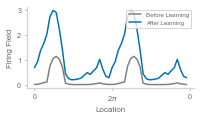

In [27]:
init_ff, ff = get_shifts(sprs, sig)
idx = np.random.choice(num_states)
plt.figure(figsize=(3, 1.5))
_init_ff = np.tile(init_ff[idx], (1,2)).squeeze()
_ff = np.tile(ff[idx], (1,2)).squeeze()
plt.plot(_init_ff, color='gray', label='Before Learning')
plt.plot(_ff, color='C0', label='After Learning')
plt.legend()
plt.ylabel('Firing Field')
plt.xlabel('Location')
plt.xticks([0, 25, 50], ['0', '2$\pi$', '0'])
plt.tight_layout()
plt.savefig('../figures/S4a.png', dpi=300, transparent=True)
plt.show()

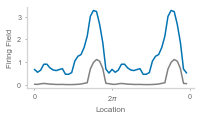

In [16]:
init_ff, ff = get_shifts(sprs, sig)
idx = np.random.choice(num_states)
plt.figure(figsize=(3, 1.5))
_init_ff = np.tile(init_ff[idx], (1,2)).squeeze()
_ff = np.tile(ff[idx], (1,2)).squeeze()
plt.plot(_init_ff, color='gray', label='After Learning')
plt.plot(_ff, color='C0', label='Before Learning')
plt.ylabel('Firing Field')
plt.xlabel('Location')
plt.xticks([0, 25, 50], ['0', '2$\pi$', '0'])
plt.tight_layout()
plt.savefig('../figures/S4b.png', dpi=300, transparent=True)
plt.show()

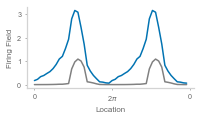

In [23]:
init_ff, ff = get_shifts(sprs, sig)
idx = np.random.choice(num_states)
plt.figure(figsize=(3, 1.5))
_init_ff = np.tile(init_ff[idx], (1,2)).squeeze()
_ff = np.tile(ff[idx], (1,2)).squeeze()
plt.plot(_init_ff, color='gray', label='After Learning')
plt.plot(_ff, color='C0', label='Before Learning')
plt.ylabel('Firing Field')
plt.xlabel('Location')
plt.xticks([0, 25, 50], ['0', '2$\pi$', '0'])
plt.tight_layout()
plt.savefig('../figures/S4c.png', dpi=300, transparent=True)
plt.show()

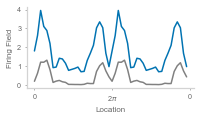

In [25]:
init_ff, ff = get_shifts(sprs, sig)
idx = np.random.choice(num_states)
plt.figure(figsize=(3, 1.5))
_init_ff = np.tile(init_ff[idx], (1,2)).squeeze()
_ff = np.tile(ff[idx], (1,2)).squeeze()
plt.plot(_init_ff, color='gray', label='After Learning')
plt.plot(_ff, color='C0', label='Before Learning')
plt.ylabel('Firing Field')
plt.xlabel('Location')
plt.xticks([0, 25, 50], ['0', '2$\pi$', '0'])
plt.tight_layout()
plt.savefig('../figures/S4d.png', dpi=300, transparent=True)
plt.show()

# One Hot


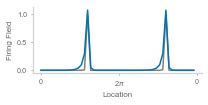

In [36]:
init_ff, ff = get_shifts(sprs, sig, onehot=True)
idx = np.random.choice(num_states)
plt.figure(figsize=(3, 1.5))
_init_ff = np.tile(init_ff[idx], (1,2)).squeeze()
_ff = np.tile(ff[idx], (1,2)).squeeze()
plt.plot(_init_ff, color='gray', label='Before Learning')
plt.plot(_ff, color='C0', label='After Learning')
plt.ylabel('Firing Field')
plt.xlabel('Location')
plt.xticks([0, 25, 50], ['0', '2$\pi$', '0'])
plt.tight_layout()
plt.savefig('../figures/S4e.png', dpi=300, transparent=True)
plt.show()

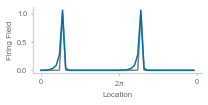

In [38]:
init_ff, ff = get_shifts(sprs, sig, onehot=True)
idx = np.random.choice(num_states)
plt.figure(figsize=(3, 1.5))
_init_ff = np.tile(init_ff[idx], (1,2)).squeeze()
_ff = np.tile(ff[idx], (1,2)).squeeze()
plt.plot(_init_ff, color='gray', label='Before Learning')
plt.plot(_ff, color='C0', label='After Learning')
plt.ylabel('Firing Field')
plt.xlabel('Location')
plt.xticks([0, 25, 50], ['0', '2$\pi$', '0'])
plt.tight_layout()
plt.savefig('../figures/S4f.png', dpi=300, transparent=True)
plt.show()